# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1VERPjEZcC1XSs4-02aM-DbkNr_yaJVbFjLJxaYQswqA/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's **totally optional** whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_**All code below should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach.**_

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [1]:
# all import statements needed for the project, for example:
import math
import bs4
import requests
import sqlalchemy as db
import pandas as pd 
import numpy as np
import datetime as dt
import matplotlib as mpl 
import matplotlib.pyplot as plt
mpl.rcParams['font.family']='serif'
plt.style.use('seaborn') 
import os 
os.chdir('/Users/yw/Desktop/4501 Project') 

In [2]:
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "uber_rides_sample.csv"
DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"

## Part 1: Data Preprocessing

### Calculating distance
For uber data, calculate the distance between the pickup and dropoff places.

$distance=2rarcsin \bigg(\sqrt { sin^2 \big( \frac{\phi_2-\phi_1}{2} \big) +cos \phi_1 · cos\phi_2  · sin^2 \big( \frac{\lambda_2 - \lambda_1}{2} \big) } \bigg) $

$\phi: \text{latitude of points};\  \lambda: \text{longtitude of points}; \ r: \text{radius of sphere}$

In [3]:
def calculate_and_add_distance(data,length): #input dataframe:([longtitude1,latitude1],[longtitude2,latitude2]) 
    r=6373 #Earth radius
    
    #use radians rather than degrees
    for i in range(length):
        data.loc[i,'picklong']=math.radians(data.loc[i,'pickup_longitude'])
        data.loc[i,'picklat']=math.radians(data.loc[i,'pickup_latitude'])
        data.loc[i,'droplong']=math.radians(data.loc[i,'dropoff_longitude'])
        data.loc[i,'droplat']=math.radians(data.loc[i,'dropoff_latitude'])
    
        data.loc[i,'distance']=2*r*math.asin(
            math.sqrt((math.sin((data.loc[i,'droplat']-data.loc[i,'picklat'])/2))**2
                  +math.cos(data.loc[i,'picklat'])*math.cos(data.loc[i,'droplat'])
                      *(math.sin((data.loc[i,'droplong']-data.loc[i,'picklong'])/2))**2))
    del data['picklong'],data['picklat'],data['droplong'],data['droplat']
    return data

### Processing Uber Data

1. Load data with pandas
2. Clean the data: 
- Remove unnecessary columns: unnamed and key
- Remove invalid data points: 1 missing data of dropoff longitude and dropoff latitude & wrong range of the longitude、latitude and passenger_count (208 passengers are too large for a car)
- Remove trips that start and/or end outside the designated coordinate box (-74.242330, 40.560445); (-73.717047, 40.560445); (-74.242330, 40.908524); (-73.717047, 40.908524)
3. Add distance column use the distance function defined above

In [4]:
uber=pd.read_csv(UBER_CSV)

In [5]:
def load_and_clean_uber_data(uber):
    uber=uber.iloc[:,2:] #drop unnecessary columns: unnamed and key
    #proper data type: UTC to YYYYMMDD HHMMSS
    uber.pickup_datetime=pd.to_datetime(uber.pickup_datetime) 
    uber['pickup_datetime']=uber['pickup_datetime'].dt.tz_localize(None)
    
    #drop missing value: only 1, compared to the 200000, can be ignored
    uber=uber[uber.dropoff_longitude.isnull()!=True]  
    uber['date']=pd.to_datetime(uber['pickup_datetime'].dt.date) #add yy-mm-dd time
    uber['week']=uber['date'].dt.dayofweek+1 
    uber=uber.sort_values('pickup_datetime').reset_index(drop=True) #sort
    
    uber=uber[uber['passenger_count']<7] #drop outlier: passenger_count=208, not possible, wrong data
    #Remove trips that start and/or end outside the designated coordinate box 
    # (40.560445, -74.242330) and (40.908524, -73.717047)
    uber=uber[(uber.pickup_longitude>=-74.242330) & (uber.pickup_longitude<=-73.717047) \
         & (uber.pickup_latitude >=40.560445 ) & (uber.pickup_latitude <= 40.908524)]
    uber=uber[(uber.dropoff_longitude>=-74.242330) & (uber.dropoff_longitude<=-73.717047) \
         & (uber.dropoff_latitude >=40.560445 ) & (uber.dropoff_latitude <= 40.908524)]
    uber=uber.reset_index(drop=True)
    return uber

In [6]:
def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(uber)
    uber_dataframe = calculate_and_add_distance(uber_dataframe,uber_dataframe.count()[0])
    return uber_dataframe

In [7]:
uber_data=get_uber_data()
uber_data.to_csv('uber.csv')

### Processing Weather Data

1. Load data
2. Separate daily data and hourly data with necessary columns, drop other columns
3. Clean data 
* Data type: 1. date: string to datetime; 2. precipitation: string to float (use 0 to replace T, which means slightly precipitation)
* Grouping: use groupby function to generate the suitable frequency like day and hour.
* Deal with wrong data: 1.Drop some wrong data of precipitation like 1.2s. 2. Use the average peak wind speed of one day before and after the wrong data to replace the 2237 miles / h speed.
4. Fill NA:
- For daily data, has 1 and 4 NA for average wind speed and peak wind speed respectively. Use the avearage value of one day before and after the missing date to fill.
- For hourly data: use the daily data to fill the missing values. Use daily precipitation divided 24 to estimate missing hourly precipitation 2. use average of windows to fill the missing value

In [8]:
weather09=pd.read_csv('2009_weather.csv',low_memory=False)
weather10=pd.read_csv('2010_weather.csv',low_memory=False)
weather11=pd.read_csv('2011_weather.csv',low_memory=False)
weather12=pd.read_csv('2012_weather.csv',low_memory=False)
weather13=pd.read_csv('2013_weather.csv',low_memory=False)
weather14=pd.read_csv('2014_weather.csv',low_memory=False)
weather15=pd.read_csv('2015_weather.csv',low_memory=False)

In [9]:
from datetime import datetime
def clean_weather_data_daily(dataframe):
    #add related daily columns
    df=pd.merge(dataframe['DATE'],dataframe['DailyPrecipitation'],left_index=True,right_index=True)
    df1=pd.merge(dataframe['DailyAverageWindSpeed'],dataframe['DailyPeakWindSpeed'],left_index=True,right_index=True)
    df2=pd.merge(df,df1,left_index=True,right_index=True)
    
    df2=df2.rename(columns=str.lower) #column name: lower letter
    df2['date']=pd.to_datetime(df2.date) #datetime type
    df2['date']=df2['date'].dt.date #to yy-mm-dd format
    df2['date']=pd.to_datetime(df2.date) #datetime type
    
    res=pd.DataFrame(df2.groupby('date')['dailyaveragewindspeed'].mean()) #groupby date to form daily data
    res['dailypeakwindspeed']=pd.DataFrame(df2.groupby('date')['dailypeakwindspeed'].mean())
    res['dailyprecipitation']=pd.DataFrame(df2.groupby('date')['dailyprecipitation'].last()) #not important for later
    return res

In [10]:
def clean_weather_data_hourly(dataframe):
    #add columns related to hourly data
    df=pd.merge(dataframe['DATE'],dataframe['DailySustainedWindSpeed'],left_index=True,right_index=True)
    df1=pd.merge(dataframe['DailyPrecipitation'],dataframe['HourlyPrecipitation'],left_index=True,right_index=True)
    df2=pd.merge(df,df1,left_index=True,right_index=True)
    
    df2.loc[df2['HourlyPrecipitation']=='T','HourlyPrecipitation']=0 #T to 0
    df2=df2.drop(df2[df2['HourlyPrecipitation'].str.contains(pat='s')==True].index) #data including 1.2s 
    df2['HourlyPrecipitation']=df2['HourlyPrecipitation'].astype(float) #to float 
    df2.loc[df2['DailyPrecipitation']=='T','DailyPrecipitation']=0 
    df2['DailyPrecipitation']=pd.to_numeric(df2['DailyPrecipitation'],errors='coerce')
    df2=df2.rename(columns=str.lower)
    df2['date']=pd.to_datetime(df2.date)
    return df2

In [11]:
def load_and_clean_weather_data():
    hourly_dataframes = []
    weather_csv_files = [weather09,weather10,weather11,weather12,weather13,weather14,weather15]
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_weather_data_hourly(csv_file)  
        hourly_dataframes.append(hourly_dataframe)
    #daily data cleaning
    daily14 = clean_weather_data_daily(weather14)
    
    #fill dailyaveragewindspeed NA: 1 NA
    # Only 1 NA: '2014-01-26' na dailyaveragewindspeed 
    # Use average of dailyaveragewindspeed of one day before and after it to replace
    average=daily14[daily14.index>='2014-01-25'][:3]['dailyaveragewindspeed'].mean()
    daily14.loc[daily14.index=='2014-01-26','dailyaveragewindspeed']=average
    
    #fill dailypeakwindspeed NA: 4 NA
    # 2014-05-08: Use average of dailypeakwindspeed of one day before and after it to replace
    average=daily14[daily14.index>='2014-05-07'][:3]['dailypeakwindspeed'].mean()
    daily14.loc[daily14.index=='2014-05-08','dailypeakwindspeed']=average
    # 2014-10-30: Use average of dailypeakwindspeed of one day before and after it to replace
    average=daily14[daily14.index>='2014-10-29'][:3]['dailypeakwindspeed'].mean()
    daily14.loc[daily14.index=='2014-10-30','dailypeakwindspeed']=average
    # 2014-07-18 & 2014-07-19: Use average of dailypeakwindspeed of 2014-07-17 and 2014-07-20 to replace
    average=daily14[daily14.index>='2014-07-17'][:4]['dailypeakwindspeed'].mean()
    daily14.loc[daily14.index=='2014-07-18','dailypeakwindspeed']=average
    daily14.loc[daily14.index=='2014-07-19','dailypeakwindspeed']=average

    #replace dailypeakwindspeed wrong data
    # On 2014-02-04, dailypeakwindspeed>2000, not possible
    # Use the average of dailypeakwindspeed of one day before and after it to replace
    before=daily14[daily14.index>='2014-02-03'][:1]['dailypeakwindspeed'][0]
    after=daily14[daily14.index>='2014-02-03'][2:3]['dailypeakwindspeed'][0]
    daily14.loc[daily14.dailypeakwindspeed>=80,'dailypeakwindspeed']=(before+after)/2
    daily=daily14
    del daily['dailyprecipitation']
    
    #hourly data cleaning
    hour = pd.concat(hourly_dataframes)
    hour['dateh']=hour['date'].dt.strftime('%Y-%m-%d %H')
    hour=hour.groupby(['dateh']).agg({'date':'last','dailysustainedwindspeed':'mean','dailyprecipitation':'mean','hourlyprecipitation':'mean'})
    
    # hourly precipitation
    # 1. Use daily precipitation /24 to estimate missing hourly precipitation
    hour.loc[hour.hourlyprecipitation.isnull()==True,'hourlyprecipitation']=hour.loc[hour.hourlyprecipitation.isnull()==True,'dailyprecipitation']/24
    # 2. use average of windows to fill the missing value
    roll=pd.DataFrame(hour.hourlyprecipitation.rolling(window=24,min_periods=1).mean())
    roll.columns=['hourlyprecipitation_roll']
    hour=pd.merge(hour,roll,left_index=True,right_index=True)
    hour.loc[((hour['hourlyprecipitation'].isnull()==True)  \
             & (hour['hourlyprecipitation_roll'].isnull()==False)),'hourlyprecipitation'] \
            = hour.loc[((hour['hourlyprecipitation'].isnull()==True)  \
             & (hour['hourlyprecipitation_roll'].isnull()==False)),'hourlyprecipitation_roll'] 
    # 3. the rest fill with 0
    hour.loc[(hour['hourlyprecipitation'].isnull()==True),'hourlyprecipitation']=0
    del hour['dailyprecipitation'],hour['hourlyprecipitation_roll']
    #sustained wind speed
    hour['ymd']=hour.date.dt.strftime('%Y-%m-%d')
    new=pd.DataFrame(hour.groupby('ymd')['dailysustainedwindspeed'].mean())
    new.columns=['sustainedwindspeed']
    new=new.reset_index()
    hour=pd.merge(hour,new,on='ymd')
    del hour['dailysustainedwindspeed'],hour['ymd']
    
    hour=hour.reset_index(drop=True) #avoid repetitive index
    daily=daily.reset_index() #index is date   
    return hour, daily

hour=load_and_clean_weather_data()[0]
daily=load_and_clean_weather_data()[1]
hour.to_csv('hour.csv')
daily.to_csv('daily.csv')

## Part 2: Storing Cleaned Data

1. use SQLAlchemy, create a SQLite database to load in preprocessed datasets;
2. create and populate 4 tables: one for sampled datasets of Yellow Taxi trips, one for Uber trips, one for hourly weather information, and one for daily weather information. 
3. create a schema.sql file that defines each table’s schema. 

In [12]:
taxi_data=pd.read_csv('taxi.csv').iloc[:,2:]
del taxi_data['hour']

In [13]:
taxi_data['pickup_datetime']=pd.to_datetime(taxi_data['pickup_datetime'])
taxi_data['dropoff_datetime']=pd.to_datetime(taxi_data['dropoff_datetime'])
taxi_data=taxi_data.sort_values('pickup_datetime').reset_index(drop=True)

In [14]:
engine = db.create_engine(DATABASE_URL)

In [15]:
HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
    id INTEGER PRIMARY KEY,
    date TEXT,
    hourlyprecipitation FLOAT,
    sustainedwindspeed FLOAT
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
    id INTEGER PRIMARY KEY,
    date TEXT,
    dailyaveragewindspeed FLOAT,
    dailypeakwindspeed FLOAT
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi (
    id INTEGER PRIMARY KEY,
    month INTEGER,
    pickup_datetime TEXT,
    dropoff_datetime TEXT,
    pickup_latitude FLOAT, 
    pickup_longitude FLOAT,
    dropoff_latitude FLOAT,
    dropoff_longitude FLOAT,
    distance FLOAT,
    tip FLOAT,
    passenger_count INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber (
    id INTEGER PRIMARY KEY,
    fare_amount FLOAT,
    pickup_datetime TEXT,
    pickup_longitude FLOAT,
    pickup_latitude FLOAT,  
    dropoff_longitude FLOAT,
    dropoff_latitude FLOAT,
    passenger_count INTEGER,
    date TEXT,
    week INTEGER,
    distance FLOAT
);
"""
 

In [16]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [17]:
# create the tables with the schema files
with engine.connect() as connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

1. define function to insert data from dataframe to SQL database
2. use dictionary to store data and data name
3. add data to database

In [18]:
def write_dataframes_to_table(table_to_df_dict):
    for k,v in map_table_name_to_dataframe.items():
        v.to_sql(k,con=engine,if_exists='append',index_label='id')  

In [19]:
map_table_name_to_dataframe = {
    "taxi": taxi_data,
    "uber": uber_data,
    "hourly_weather": hour,
    "daily_weather": daily,
}

In [20]:
write_dataframes_to_table(map_table_name_to_dataframe)

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [√] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [√] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [√] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [21]:
def write_query_to_file(query, outfile):
    with open(outfile, 'w') as file:
        file.write(query)

### Query N

1. define a SQL query for each of the following questions - one query per question. 
2. Save each query as a .sql file, naming it something illustrative of what the query is for, e.g. top_10_hottest_days.sql.

$Question \ 2$

$\text{From 01-2009 to 06-2015, what day of the week was the most popular to take an uber? The result should have 7 bins.}$

In [22]:
QUERY_2 = """
SELECT week, COUNT(week) FROM (SELECT DISTINCT week,date FROM uber
WHERE date BETWEEN "2009-01-01" AND "2015-07-01" )
GROUP BY week
ORDER BY COUNT(week) DESC
"""

In [23]:
engine.execute(QUERY_2).fetchall()

[(7, 339), (6, 339), (5, 339), (4, 339), (2, 339), (1, 339), (3, 338)]

In [24]:
write_query_to_file(QUERY_2, "popular_day_of_week_uber.sql")

$ Question \ 3$

$\text{What is the 95% percentile of distance traveled for all hired trips during July 2013?}$

In [25]:
QUERY_3="""
WITH two AS 
(SELECT pickup_datetime,distance FROM uber
WHERE "2013-06-30T00:00"< pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00'
UNION ALL
SELECT pickup_datetime,distance FROM taxi
WHERE "2013-06-30T00:00"<pickup_datetime AND pickup_datetime < '2013-07-31T00:00:00')

SELECT distance AS '95%distance'FROM two
ORDER BY distance 
LIMIT 1
OFFSET (SELECT COUNT(*)
        FROM two) * 95 / 100 - 1 ;
"""

In [26]:
engine.execute(QUERY_3).fetchall()

[(10.234680206341519,)]

In [27]:
write_query_to_file(QUERY_3, "95%percentile_distance.sql")

$Question \ 5$

$\text{Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?}$

In [28]:
#peak wind speed
QUERY_5 = """
WITH ride AS
(SELECT DATE(pickup_datetime) AS date, count(pickup_datetime) AS count from (SELECT pickup_datetime FROM uber
WHERE "2013-12-31T00:00"< pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00'
UNION ALL
SELECT pickup_datetime FROM taxi
WHERE "2013-12-31T00:00"<pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00')
GROUP BY DATE(pickup_datetime))

SELECT * FROM(SELECT DATE(daily_weather.date) AS date, daily_weather.dailyaveragewindspeed, 
daily_weather.dailypeakwindspeed, ride.count
FROM daily_weather 
LEFT OUTER JOIN ride 
ON DATE(daily_weather.date)=DATE(ride.date)
ORDER BY daily_weather.dailypeakwindspeed DESC
LIMIT 10
)
"""

In [29]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.1, 40.0, 106),
 ('2014-12-07', 11.8, 40.0, 73),
 ('2014-02-13', 12.6, 39.0, 63),
 ('2014-02-27', 8.4, 39.0, 102),
 ('2014-01-07', 13.1, 38.0, 557),
 ('2014-02-14', 10.4, 38.0, 71),
 ('2014-03-26', 11.9, 38.0, 96),
 ('2014-04-05', 8.4, 36.0, 92),
 ('2014-04-23', 9.4, 36.0, 75),
 ('2014-11-02', 10.8, 36.0, 80)]

In [30]:
#average wind speed
QUERY_5 = """
WITH ride AS
(SELECT DATE(pickup_datetime) AS date, count(pickup_datetime) AS count from (SELECT pickup_datetime FROM uber
WHERE "2013-12-31T00:00"< pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00'
UNION ALL
SELECT pickup_datetime FROM taxi
WHERE "2013-12-31T00:00"<pickup_datetime AND pickup_datetime < '2014-12-31T00:00:00')
GROUP BY DATE(pickup_datetime))

SELECT * FROM(SELECT DATE(daily_weather.date) AS date, daily_weather.dailyaveragewindspeed, 
daily_weather.dailypeakwindspeed, ride.count
FROM daily_weather 
LEFT OUTER JOIN ride 
ON DATE(daily_weather.date)=DATE(ride.date)
ORDER BY daily_weather.dailyaveragewindspeed DESC
LIMIT 10
)
"""

In [31]:
engine.execute(QUERY_5).fetchall()

[('2014-03-13', 14.1, 40.0, 106),
 ('2014-01-07', 13.1, 38.0, 557),
 ('2014-02-13', 12.6, 39.0, 63),
 ('2014-01-02', 12.2, 28.0, 447),
 ('2014-03-26', 11.9, 38.0, 96),
 ('2014-12-07', 11.8, 40.0, 73),
 ('2014-12-08', 11.5, 29.0, 77),
 ('2014-03-29', 10.8, 35.0, 107),
 ('2014-11-02', 10.8, 36.0, 80),
 ('2014-01-03', 10.4, 29.0, 321)]

In [32]:
write_query_to_file(QUERY_5, "top10_windest_hiredtrips.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [√] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [√] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [√] Create another scatter plot that compares tip amount versus precipitation amount.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization 2
$Question \ 2$：
Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization


Use of the `matplotlib` to visualize and `norm` library to calculate the confidence level. 

Confidence level:

Since this data set is very big, so according to the law of large numbers, it approximately follows the normal distribution.

$\big[\bar Y - z\times \frac{s}{\sqrt{n}}, \bar Y + z\times \frac{s}{\sqrt{n}}\big]$

In [33]:
def get_data_for_visual_n(stmt):
    df=pd.read_sql(stmt,engine.connect())
    return df

In [34]:
def plot_visual_confidence(dataframe):
    fig, ax = plt.subplots(figsize=(6,3))
    from scipy.stats import norm
    z=norm.ppf(0.9)
    x=pd.Series(dataframe.index)
    y=dataframe['distance']
    s=y.std()
    n=dataframe.count()[0]
    y_err=z*s/np.sqrt(n)
    x_ticks = np.linspace(1, 12, 12)
    plt.xticks(x_ticks)
    plt.xlabel('Month')
    plt.ylabel('Distance')
    ax.plot(x,y)
    ax.fill_between(x, y - y_err, y + y_err, alpha=0.2)
    ax.set_title("Confidence level of distanace")
    plt.show()

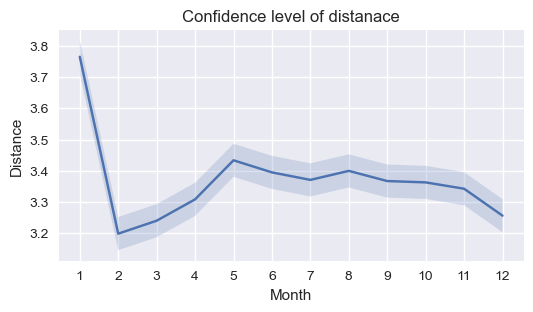

In [35]:
stmt="""
        SELECT Date(pickup_datetime) AS date,distance FROM uber
        UNION 
        SELECT Date(pickup_datetime) AS date,distance FROM taxi
        """
df2 = get_data_for_visual_n(stmt)
df2['date']=pd.to_datetime(df2['date'])
df2['month']=pd.DatetimeIndex(df2['date']).month
distance_mean=pd.DataFrame(df2.groupby(['month'])['distance'].mean())
plot_visual_confidence(distance_mean)

### Visualization 4
$Question \ 4$：Create a heatmap of all hired trips over a map of the area

Use keplergl library to get the heatmap of the location

In [36]:
stmt="""
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM uber
        UNION
        SELECT pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude 
        FROM taxi
        """
df4 = get_data_for_visual_n(stmt)

In [37]:
def plot_visual_heatmap(dataframe):
    from keplergl import KeplerGl
    map1=KeplerGl(height=500)
    map1.add_data(data=dataframe,name='New York City Taxi and Uber Trips')
    return map1
plot_visual_heatmap(df4)

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'New York City Taxi and Uber Trips': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

### Visualization 6
$Question \ 6$：Create another scatter plot that compares tip amount versus precipitation amount.

Use the pandas to merge the tip amount and precipitation data and then use the matplot library to get the scatter plot.

In [38]:
stmt="""
SELECT strftime('%Y-%m-%d %H',pickup_datetime) AS dateh, pickup_datetime,tip
FROM taxi
"""
stmt1="""
SELECT strftime('%Y-%m-%d %H',date) AS dateh, date, hourlyprecipitation 
FROM hourly_weather
"""
taxidf=get_data_for_visual_n(stmt)
hourdf=get_data_for_visual_n(stmt1)
df7=pd.merge(taxidf,hourdf,how='left')

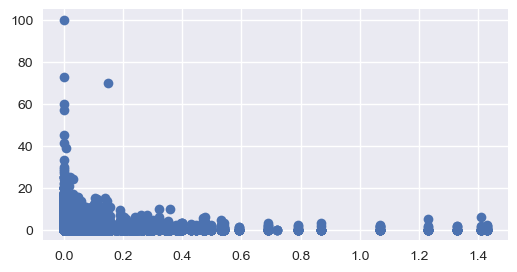

In [39]:
# use a more descriptive name for your function
def plot_visual_6(dataframe):
    plt.figure(figsize=(6,3))
    plt.plot(dataframe['hourlyprecipitation'],dataframe['tip'],'o')
    #plt.xlim(-0.01,0.5)
    plt.show()
plot_visual_6(df7)